# Scratch notebook for experimenting with ridge trace algorithm

## Basic plan

0. We use a map of surface brightness, which we will call $B$
1. We start at some point on the emission arc that we want to trace. For instance, the local maximum brightness
2. Find the two perpendicular directions of the principal curvature: $\hat{n}_1$, $\hat{n}_2$
3. Take a step parallel to $\hat{n}_2$, which should be tangential to the arc
4. Then look along the direction $\hat{n}_1$ to find the point of maximum $B$ and set this as the next point on the arc
5. Return to step 2 and repeat
6. We need some criterion for saying when we should stop

In [1]:
import sys
from pathlib import Path
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("talk")
from ridge_trace.curvature import ImageCurvature
from ridge_trace import trace

In [2]:
sys.version_info

sys.version_info(major=3, minor=12, micro=1, releaselevel='final', serial=0)

## Load the image data from FITS files

In [3]:
datapath = Path.cwd().parent / "data"
fitsfiles = list(datapath.glob("*.fits"))
proplyd = "069-601"
hdu = fits.open(fitsfiles[1])["SCI"]

Calculate curvatures as in demo01 notebook

In [4]:
x1, x2 = 250, 420
y1, y2 = 250, 420
v0, d0 = 1.0, 20
ic = ImageCurvature(
    hdu.data, 
    smooth=2.5, 
    sharp=40, 
    max_cutoff=8.5, 
    bbox=[x1, y1, x2, y2], 
    scales=(v0, d0),
)

## Look at traces through the image from the peak


In [5]:
indices = trace.peak_indices(-ic.kappa1)

In [6]:
indices, ic.kappa1[indices], ic.theta2[indices]

((114, 93), -8.541056619175908, 168.65927441248357)

Take the straight line in the direction of max curvature, and also the opposite direction.

In [7]:
y0, x0 = indices
line = trace.StraightLine(x0, y0, ic.theta2[indices])
line2 = trace.StraightLine(x0, y0, ic.theta2[indices] + 180)
line3 = trace.StraightLine(x0, y0, ic.theta1[indices])
line4 = trace.StraightLine(x0, y0, ic.theta1[indices] + 180)
line

StraightLine(x0=93, y0=114, theta=168.65927441248357)

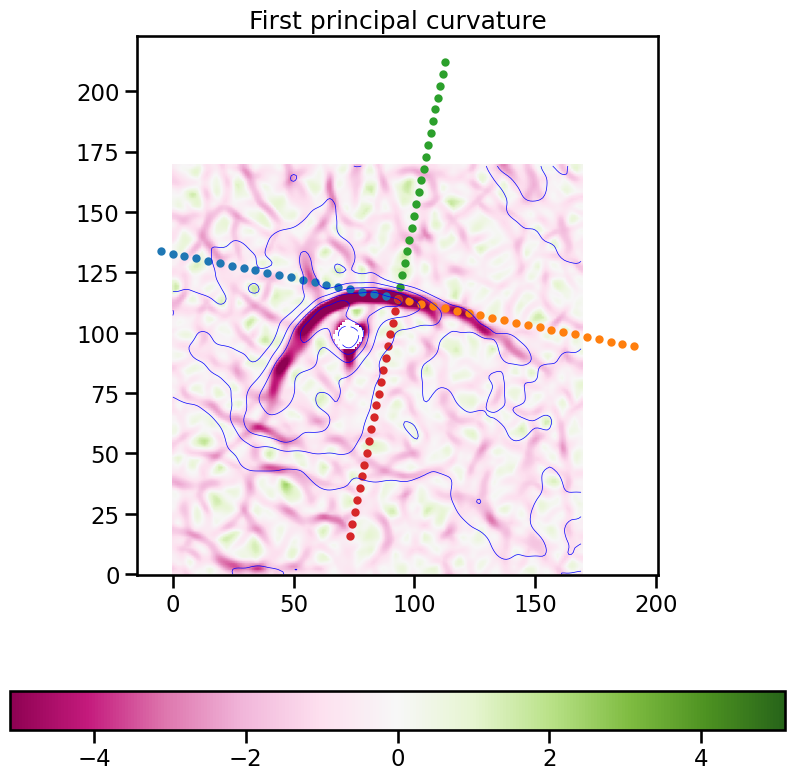

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
m = np.isfinite(ic.kappa1)
kappa_cmap = 'PiYG'
vmin, vmax = np.percentile(ic.kappa1[m], [1, 99])
im1 = ax.imshow(ic.kappa1, origin='lower', vmin=vmin, vmax=-vmin, cmap=kappa_cmap)
fig.colorbar(im1, ax=ax, orientation="horizontal")
levels = 0.0 + np.arange(7) * 0.15
ax.contour(ic.image, levels=levels, colors="blue", linewidths=0.5)
ax.scatter(line.points.x[::5], line.points.y[::5], marker=".", color='C0')
ax.scatter(line2.points.x[::5], line2.points.y[::5], marker=".", color='C1')
ax.scatter(line3.points.x[::5], line3.points.y[::5], marker=".", color='C2')
ax.scatter(line4.points.x[::5], line4.points.y[::5], marker=".", color='C3')
ax.set_title("First principal curvature")
...;

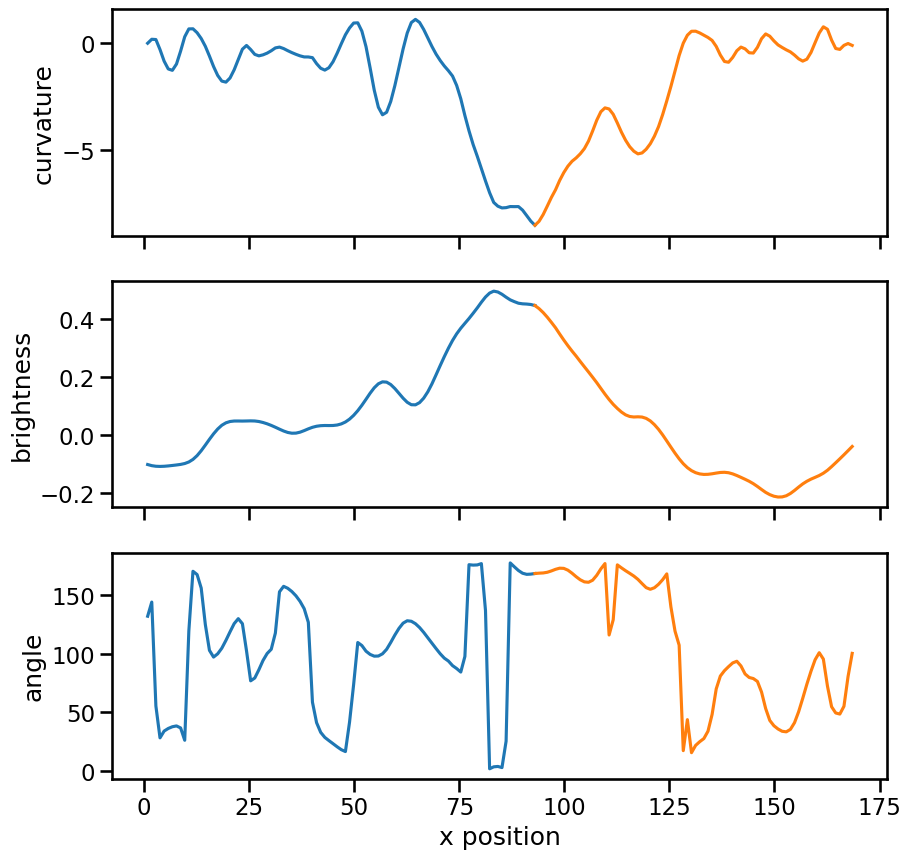

In [9]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axes[0].plot(line.points.x, line.image_values(ic.kappa1))
axes[0].plot(line2.points.x, line2.image_values(ic.kappa1))
axes[1].plot(line.points.x, line.image_values(ic.image))
axes[1].plot(line2.points.x, line2.image_values(ic.image))
axes[2].plot(line.points.x, line.image_values(ic.theta2))
axes[2].plot(line2.points.x, line2.image_values(ic.theta2))
axes[0].set(ylabel="curvature")
axes[1].set(ylabel="brightness")
axes[2].set(xlabel="x position", ylabel="angle")

...;

In [10]:
thm = np.where(ic.kmean < 0, ic.theta1, ic.theta2)

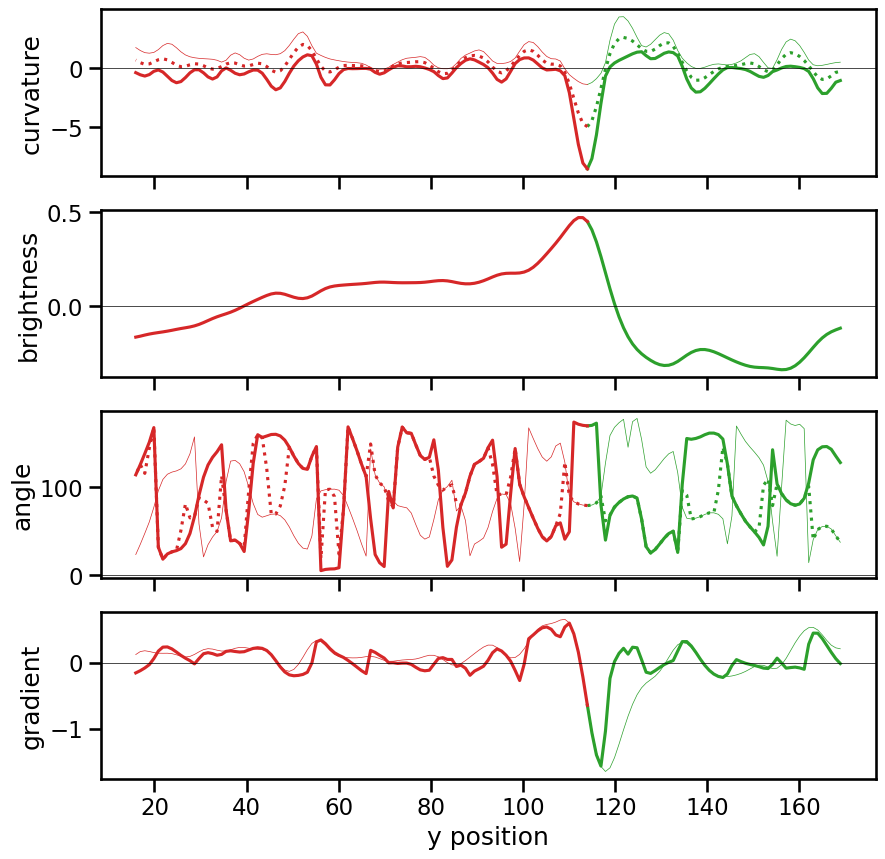

In [11]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 10))
axes[0].plot(line3.points.y, line3.image_values(ic.kappa1), color='C2')
axes[0].plot(line4.points.y, line4.image_values(ic.kappa1), color='C3')
axes[0].plot(line3.points.y, line3.image_values(ic.kappa2), color='C2', lw=0.5)
axes[0].plot(line4.points.y, line4.image_values(ic.kappa2), color='C3', lw=0.5)
axes[0].plot(line3.points.y, line3.image_values(ic.kmean), color='C2', ls="dotted")
axes[0].plot(line4.points.y, line4.image_values(ic.kmean), color='C3', ls="dotted")
axes[1].plot(line3.points.y, line3.image_values(ic.image), color='C2')
axes[1].plot(line4.points.y, line4.image_values(ic.image), color='C3')
axes[2].plot(line3.points.y, line3.image_values(ic.theta2), color='C2')
axes[2].plot(line4.points.y, line4.image_values(ic.theta2), color='C3')
axes[2].plot(line3.points.y, line3.image_values(ic.theta1), color='C2', lw=0.5)
axes[2].plot(line4.points.y, line4.image_values(ic.theta1), color='C3', lw=0.5)
axes[2].plot(line3.points.y, line3.image_values(thm), color='C2', ls="dotted")
axes[2].plot(line4.points.y, line4.image_values(thm), color='C3', ls="dotted")
axes[3].plot(line3.points.y, line3.image_values(ic.grad_y), color='C2', lw=0.5)
axes[3].plot(line4.points.y, line4.image_values(ic.grad_y), color='C3', lw=0.5)
axes[3].plot(line3.points.y, line3.image_values(ic.grad1), color='C2')
axes[3].plot(line4.points.y, line4.image_values(ic.grad1), color='C3')
axes[0].set(ylabel="curvature")
axes[1].set(ylabel="brightness")
axes[2].set(ylabel="angle")
axes[3].set(xlabel="y position", ylabel="gradient")
for ax in axes:
    ax.axhline(0.0, color='k', lw=0.5)
...;

## Making use of the gradients (first derivatives)

The gradient dotted with the first principal direction is the first derivative across the ridge, which should be zero at the ridge. 



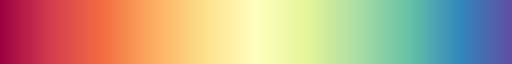

In [12]:
import matplotlib as mpl
#list(mpl.colormaps)
grad_cmap = mpl.colormaps['Spectral']
grad_cmap

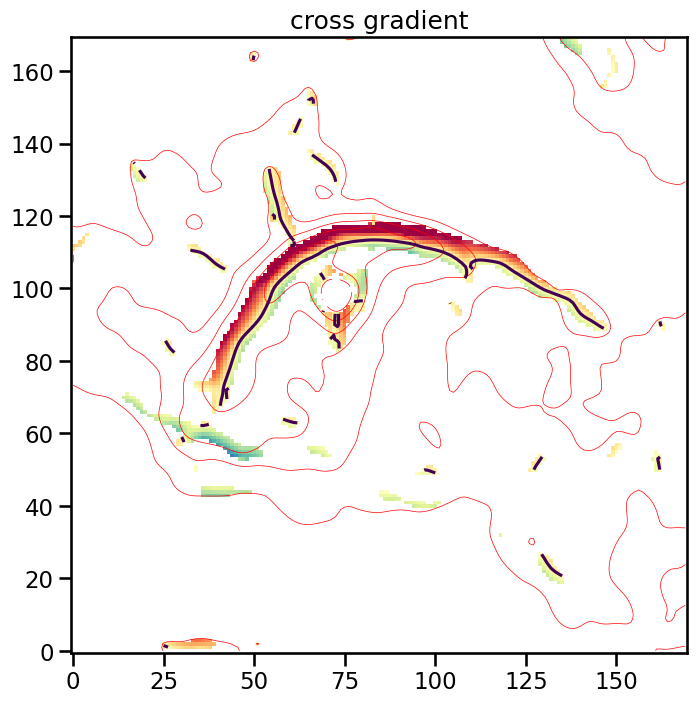

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
vmin, vmax = -1, 1
mask = (ic.kappa1 < -2) & (ic.image > levels[0])
alpha = mask.astype(float)
im1 = ax.imshow(ic.grad1, origin='lower', vmin=vmin, vmax=vmax, alpha=alpha, cmap=grad_cmap)
ax.contour(ic.image, levels=levels, colors="red", linewidths=0.5)
cset = ax.contour(np.where(mask, ic.grad1, np.nan), levels=[0])
ax.set_title("cross gradient")
...;

Repeat the contour calculation using contourpy directly

In [14]:
from contourpy import contour_generator
cont_gen = contour_generator(z=np.where(mask, ic.grad1, np.nan), quad_as_tri=True)

In [15]:
lines = cont_gen.lines(0.0)

Get the longest segments from the contour lines

In [16]:
lines.sort(key=len, reverse=True)
lines[:3]

[array([[108.17730083, 102.82269917],
        [108.30116503, 103.        ],
        [108.54502777, 103.45497223],
        [108.54791359, 103.54791359],
        [108.67032771, 104.        ],
        [108.67182676, 104.32817324],
        [108.6445808 , 104.6445808 ],
        [108.64593548, 105.        ],
        [108.5392249 , 105.4607751 ],
        [108.53237447, 105.53237447],
        [108.37753542, 106.        ],
        [108.20754722, 106.20754722],
        [108.        , 106.33242964],
        [107.69130704, 106.69130704],
        [107.37468053, 107.        ],
        [107.16531132, 107.16531132],
        [107.        , 107.27787374],
        [106.59198875, 107.59198875],
        [106.06858389, 108.        ],
        [106.02827546, 108.02827546],
        [106.        , 108.0468785 ],
        [105.86924516, 108.13075484],
        [105.41782839, 108.41782839],
        [105.        , 108.69426759],
        [104.80384557, 108.80384557],
        [104.4912093 , 109.        ],
        [104

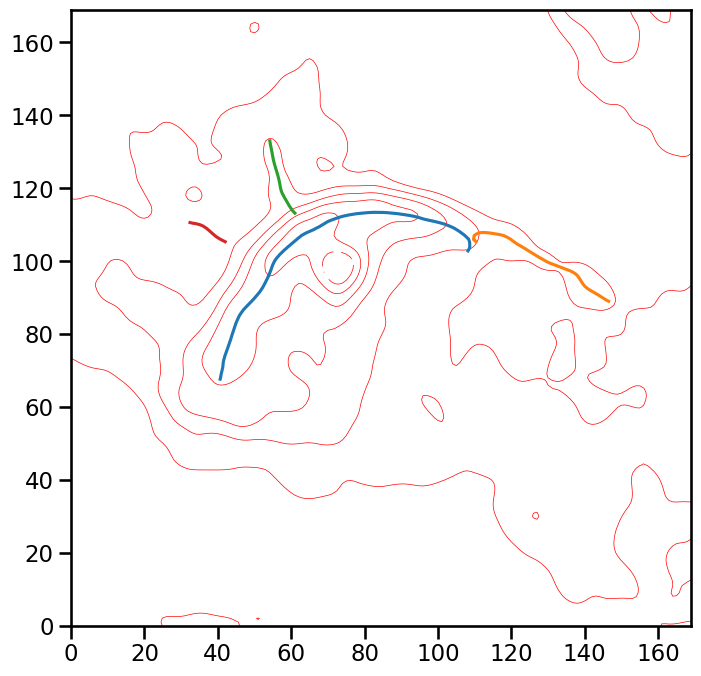

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.contour(ic.image, levels=levels, colors="red", linewidths=0.5)
for line in lines[:4]:
    x, y = zip(*line)
    ax.plot(x, y)

...;

So this works great. We could try to merge together the different sections. 



### Look for zero of the curvature to find the arc boundaries

This time we want to select large positiver values of the cross gradient for the outer boundary and large negative values for the inner boundary

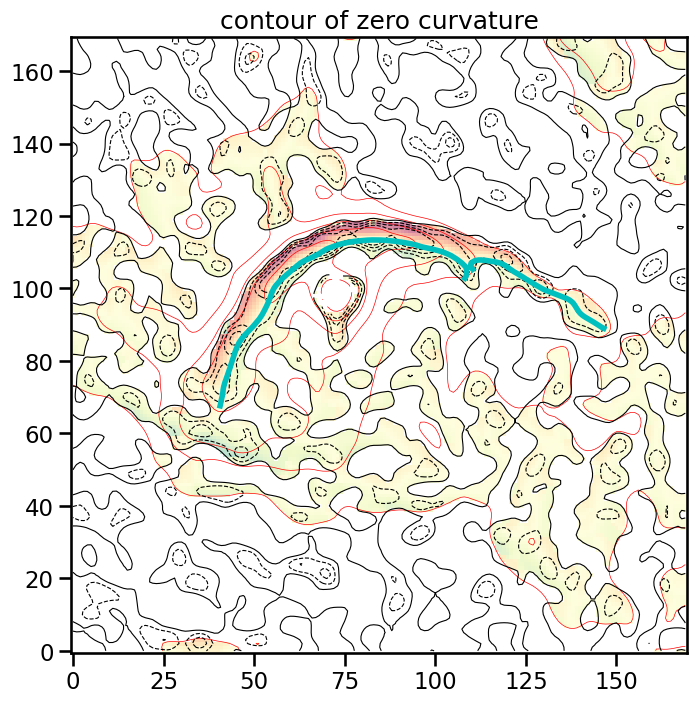

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))
vmin, vmax = -1.5, 1.5
mask = (np.abs(ic.grad1) >= 0.0)  & (ic.image > levels[0]) & (ic.kmean < 0) 
alpha = mask.astype(float)
im1 = ax.imshow(ic.grad1, origin='lower', vmin=vmin, vmax=vmax, alpha=0.5 * alpha, cmap=grad_cmap)
ax.contour(ic.image, levels=levels, colors="red", linewidths=0.5)
cset = ax.contour(ic.kmean, levels=[-3, -2, -1, 0], linewidths=0.8, colors='k')
for line in lines[:2]:
    x, y = zip(*line)
    ax.plot(x, y, lw=4, c="c")
ax.set_title("contour of zero curvature")
...;

So this sort of works. We do get the contour of zero mean curvature that bounds the shell. But we get a whole bunch of orther zero curvature contours too.  Note that the mean curvature is what we have to use now that I have made it so kappa1 is always lower than kappa2. 

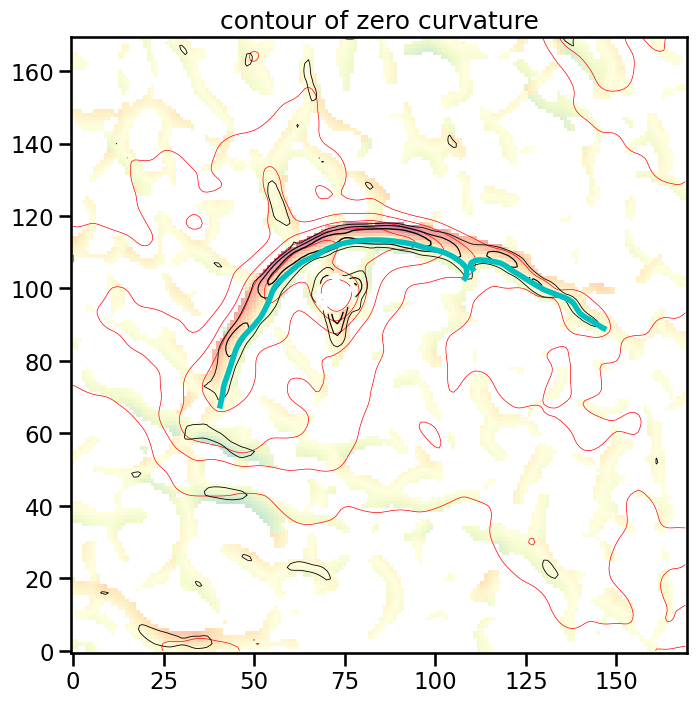

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))
vmin, vmax = -1.5, 1.5
mask = (np.abs(ic.grad1) >= 0.0)  & (ic.kappa1 < -1)
alpha = mask.astype(float)
im1 = ax.imshow(ic.grad1, origin='lower', vmin=vmin, vmax=vmax, alpha=0.5 * alpha, cmap=grad_cmap)
ax.contour(ic.image, levels=levels, colors="red", linewidths=0.5)
#csetm = ax.contour(ic.kmean, levels=[0], linewidths=0.8, colors='k')
cset1 = ax.contour(-ic.kappa1, levels=[2.5, 4.5, 6.5], linewidths=[0.6, 0.8, 1.0], colors='k')

for line in lines[:2]:
    x, y = zip(*line)
    ax.plot(x, y, lw=4, c="c")
ax.set_title("contour of zero curvature")
...;

### Calculate the curvature scale and maybe take a contour of that



So no, this is far worse than just using kmean directly. I have deleted all these figures because they are really ugly and serve no purpose

## Repeat with the other fits file

In [20]:
proplyd = "000-400"
hdu = fits.open(fitsfiles[0])["SCI"]

In [21]:
x1, x2 = 200, 500
y1, y2 = 600, 900
v0, d0 = 0.1, 20
ic = ImageCurvature(
    hdu.data, 
    smooth=6, 
    sharp=50, 
    max_cutoff=3.7, 
    bbox=[x1, y1, x2, y2], 
    scales=(v0, d0),
)

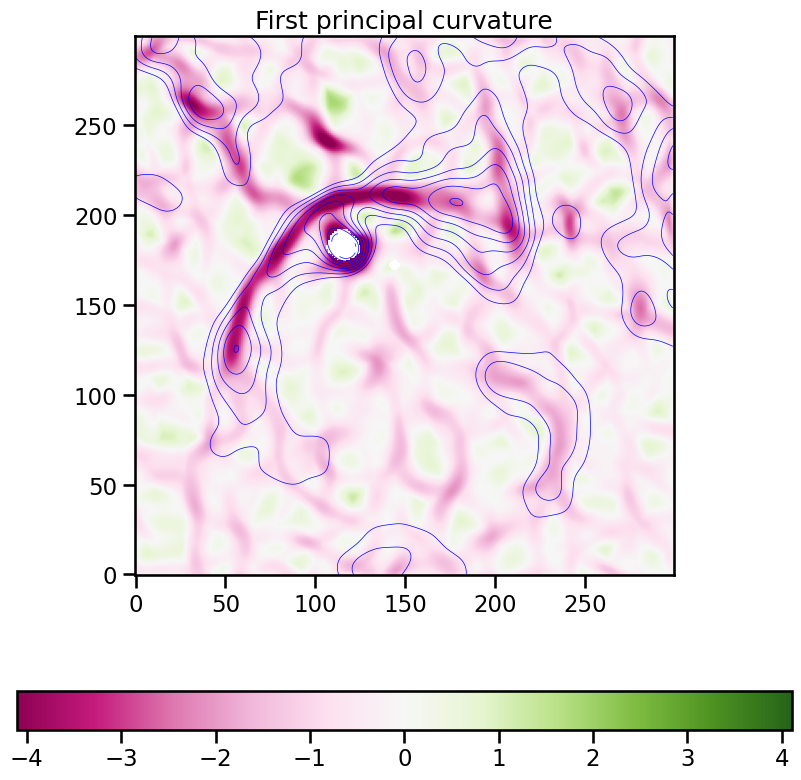

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
m = np.isfinite(ic.kappa1)
kappa_cmap = 'PiYG'
vmin, vmax = np.percentile(ic.kappa1[m], [0.5, 99.5])
im1 = ax.imshow(ic.kappa1, origin='lower', vmin=vmin, vmax=-vmin, cmap=kappa_cmap)
fig.colorbar(im1, ax=ax, orientation="horizontal")
levels = 0.01 + np.arange(8) * 0.02
#levels = 0.0 + np.arange(7) * 0.15
ax.contour(ic.image, levels=levels, colors="blue", linewidths=0.5)
ax.set_title("First principal curvature")
...;

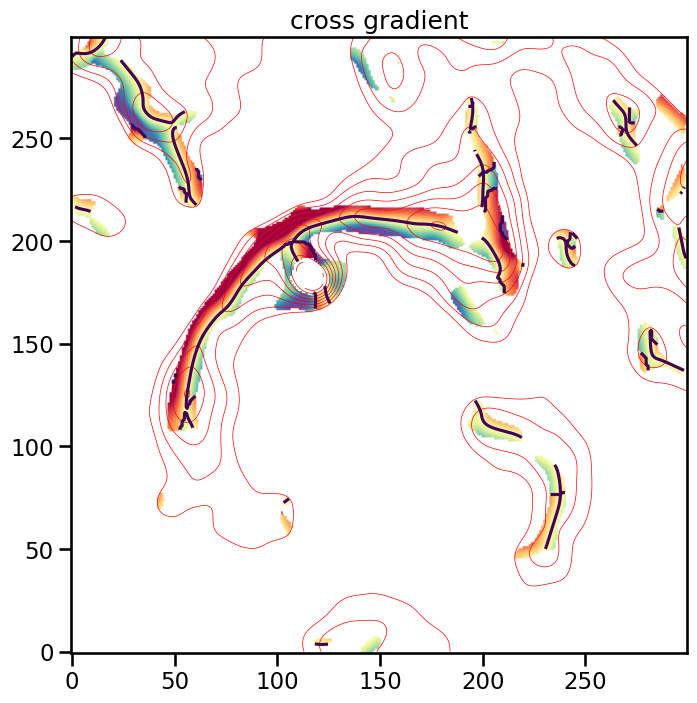

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
vmin, vmax = -1, 1
mask = (ic.kappa1 < -1.5) & (ic.image > levels[0])
alpha = mask.astype(float)
im1 = ax.imshow(ic.grad1, origin='lower', vmin=vmin, vmax=vmax, alpha=alpha, cmap=grad_cmap)
ax.contour(ic.image, levels=levels, colors="red", linewidths=0.5)
cset = ax.contour(np.where(mask, ic.grad1, np.nan), levels=[0])
ax.set_title("cross gradient")
...;

In [24]:
cont_gen = contour_generator(z=np.where(mask, ic.grad1, np.nan), quad_as_tri=True)
lines = cont_gen.lines(0.0)
lines.sort(key=len, reverse=True)

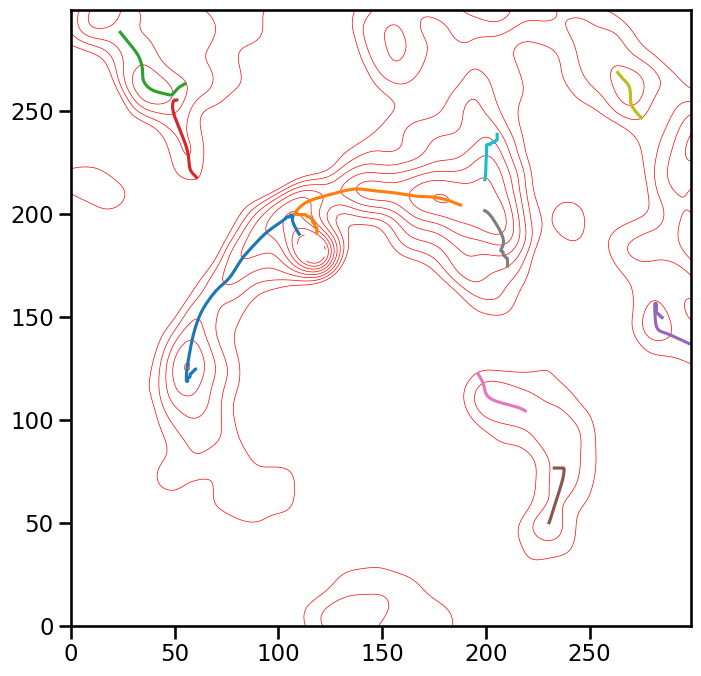

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.contour(ic.image, levels=levels, colors="red", linewidths=0.5)
for line in lines[:10]:
    x, y = zip(*line)
    ax.plot(x, y)

...;

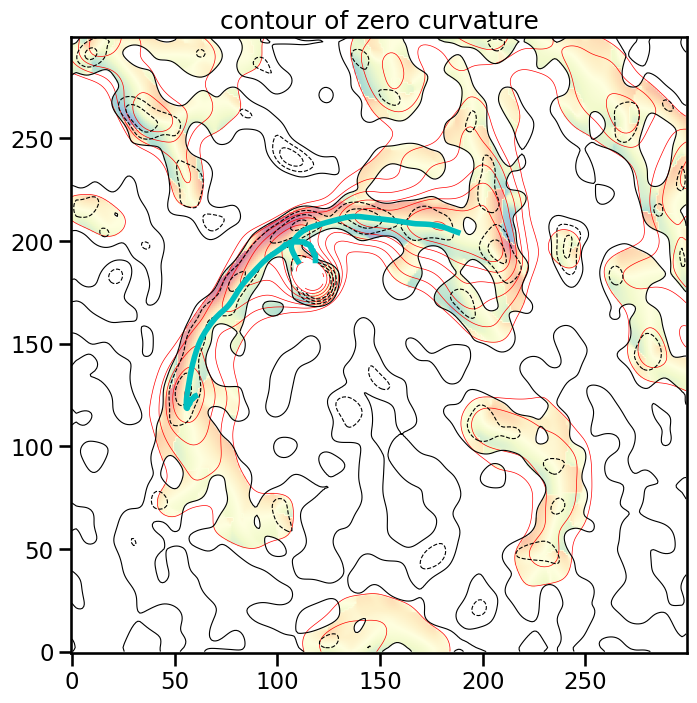

In [29]:
fig, ax = plt.subplots(figsize=(8, 8))
vmin, vmax = -1.5, 1.5
mask = (np.abs(ic.grad1) >= 0.0) & (ic.image > levels[0]) & (ic.kmean < 0.0) 
alpha = mask.astype(float)
im1 = ax.imshow(ic.grad1, origin='lower', vmin=vmin, vmax=vmax, alpha=0.5 * alpha, cmap=grad_cmap)
ax.contour(ic.image, levels=levels, colors="red", linewidths=0.5)
cset = ax.contour(ic.kmean, levels=[-3, -2, -1, 0], linewidths=0.8, colors='k')
for line in lines[:2]:
    x, y = zip(*line)
    ax.plot(x, y, lw=4, c="c")
ax.set_title("contour of zero curvature")
...;